In [2]:
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.tseries.offsets import DateOffset 
from sklearn.preprocessing import MinMaxScaler
from lineartree import LinearTreeRegressor
from joblib import dump, load

# 1 - Fitting models

In this section, we fit the arbitration models on past data. Please note that there are some other models used for the projection of France retail market which were fitted in an Excel as they are simple linear regressions.
<br>Business insights
<br>France retail market projection is decomposed as follows,
<br>oals : Projecting both credits (mortgages & consumer credits) as well as deposits in France
<br>Simplfified mecanism : Projecting credits using linear regressions, adding revenues (RISQ ETU driver) and substracting consumption & investments (RISQ ETU drivers) -> total deposits <br>variation for each time steps as the resulting amount represents the leftover to place on deposits
<br>Steps at each timestep :
<br>1 - Project credits using linear regression models (goal #1 completed)
<br>2 - Using 1 and RISQ ETU drivers, determine the deposit variation
<br>3 - Add deposit variation to current outstanding
<br>4 - Use the arbitration model to allocate total deposit outstanding to each deposit
<br>5 - generate interests from deposits, depending on their interest rates (either RISQ ETU driver or projected using bacic rules / linear regressions)

C:\Users\Admin\AppData\Local\Temp\ipykernel_44304\1576744656.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['total'] = df_train[target_to_drivers.keys()].sum(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_44304\1576744656.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[k+'_ratio'] = df_train[k]/df_train['total']
C:\Users\Admin\AppData\Local\Temp\ipykernel_44304\1576744656.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

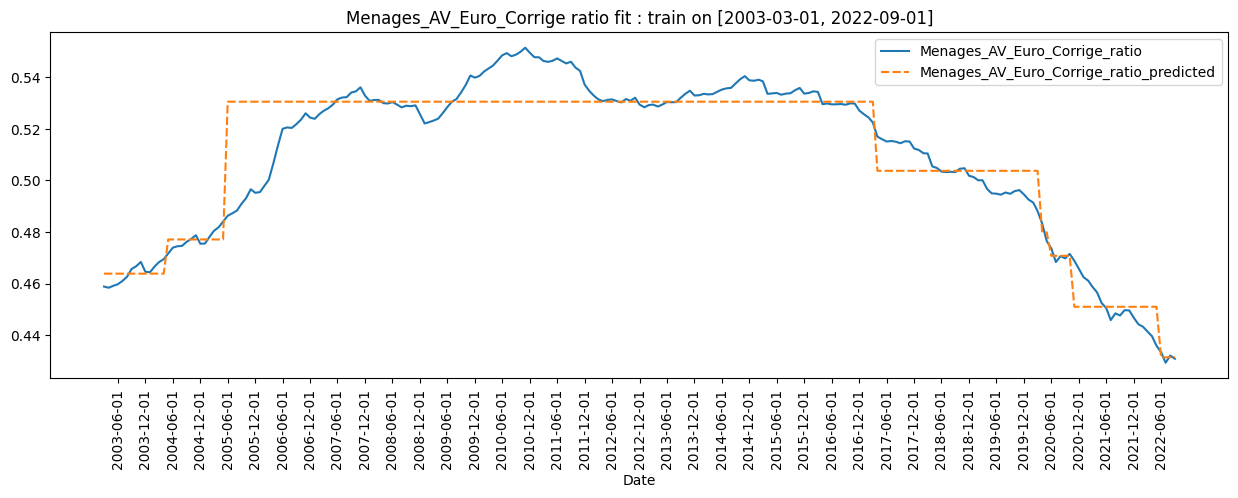

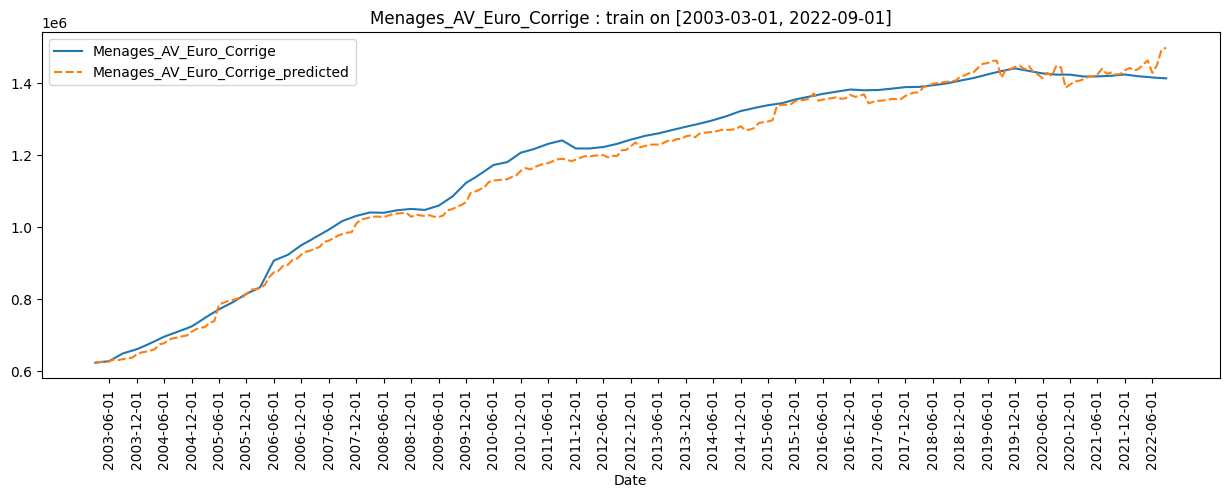

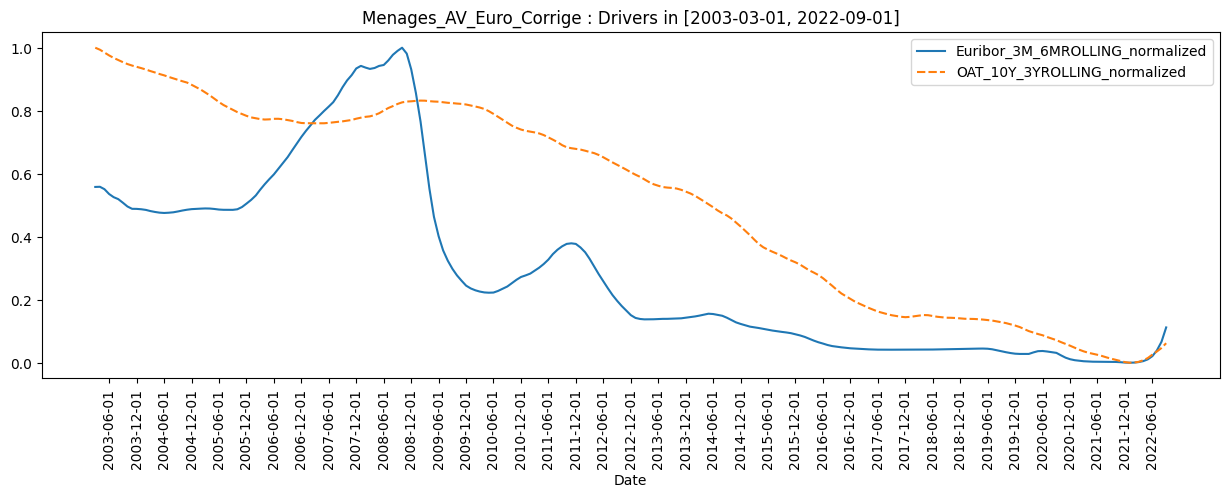

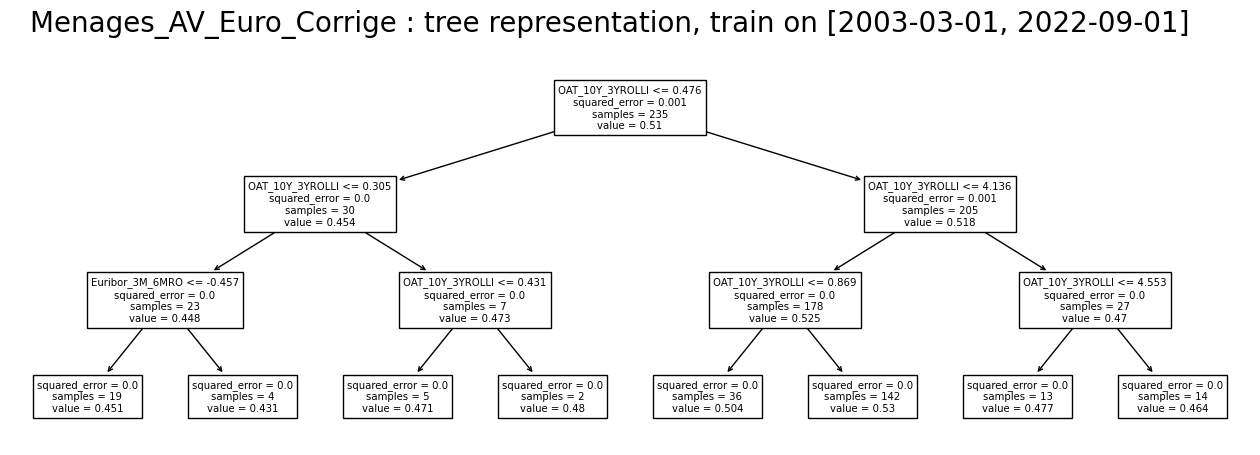

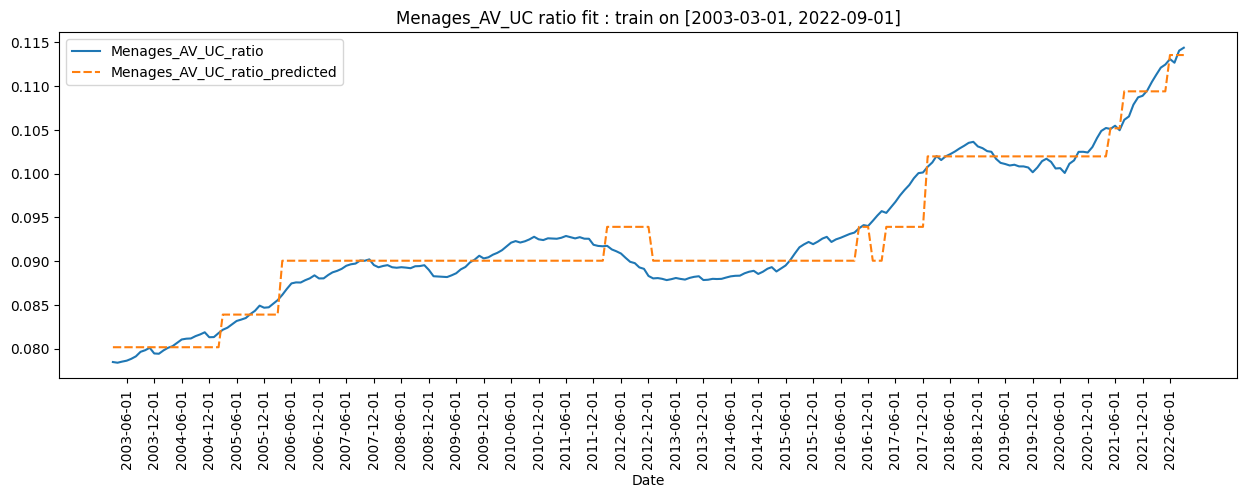

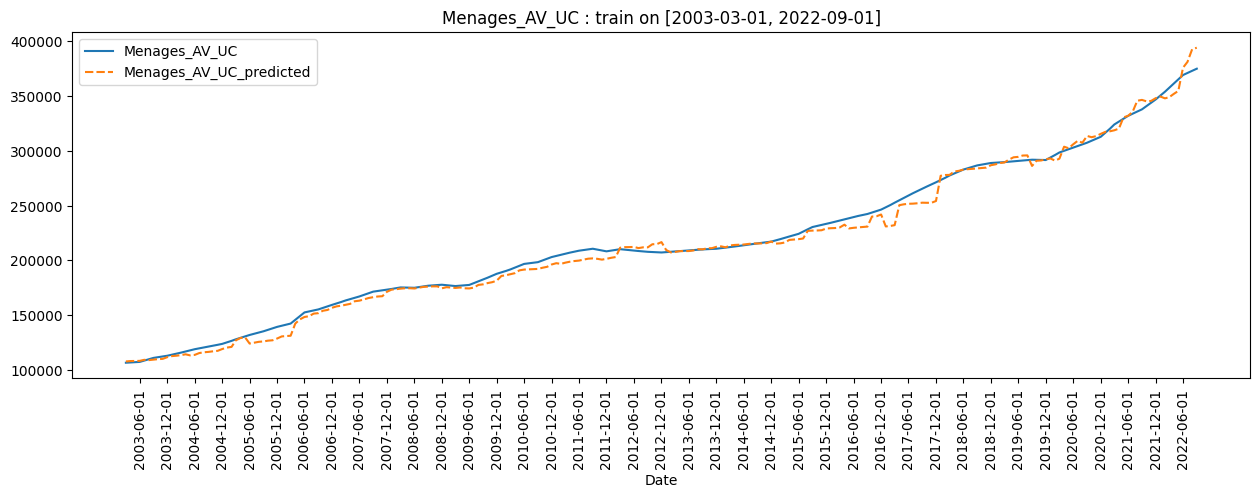

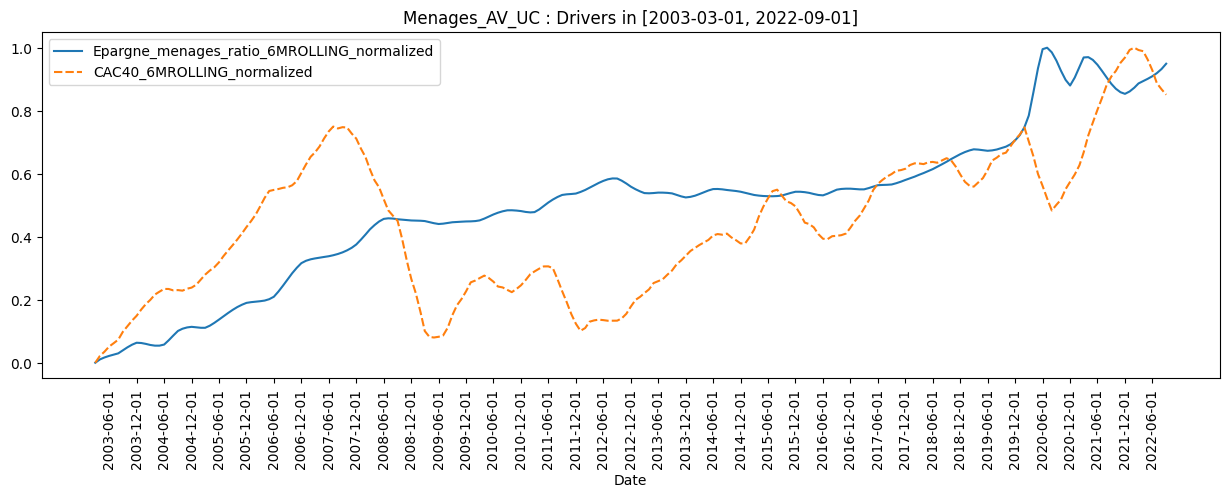

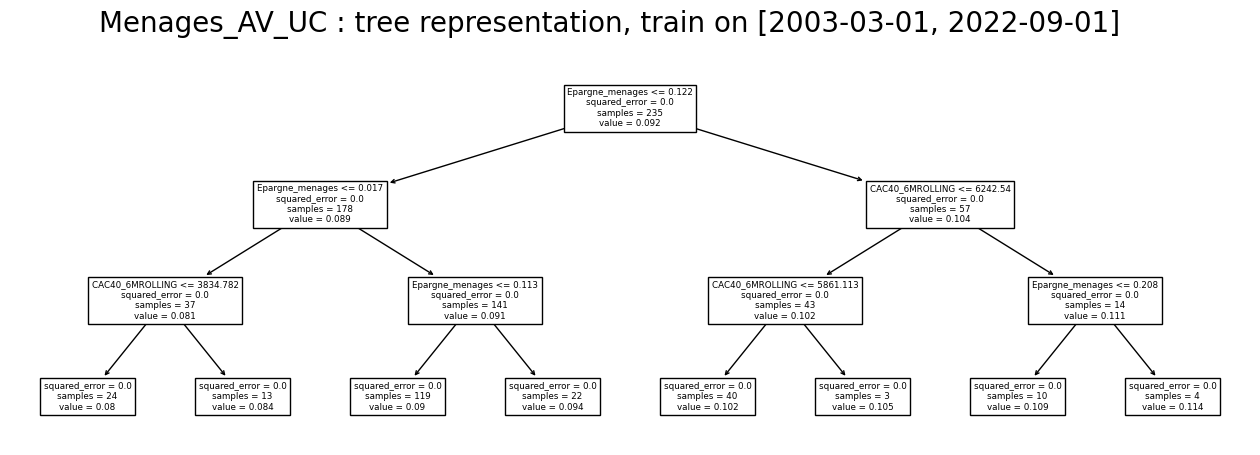

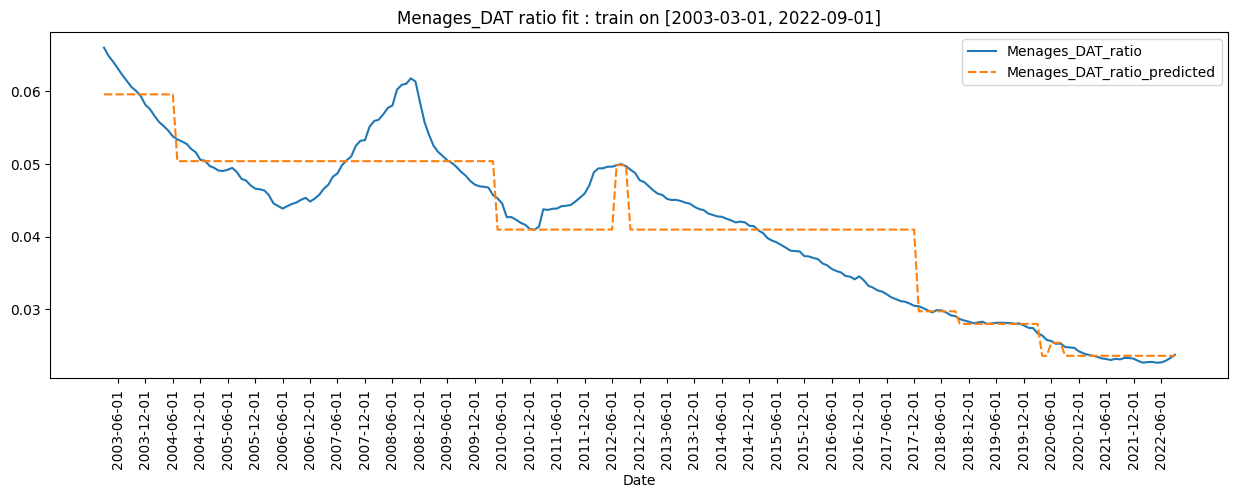

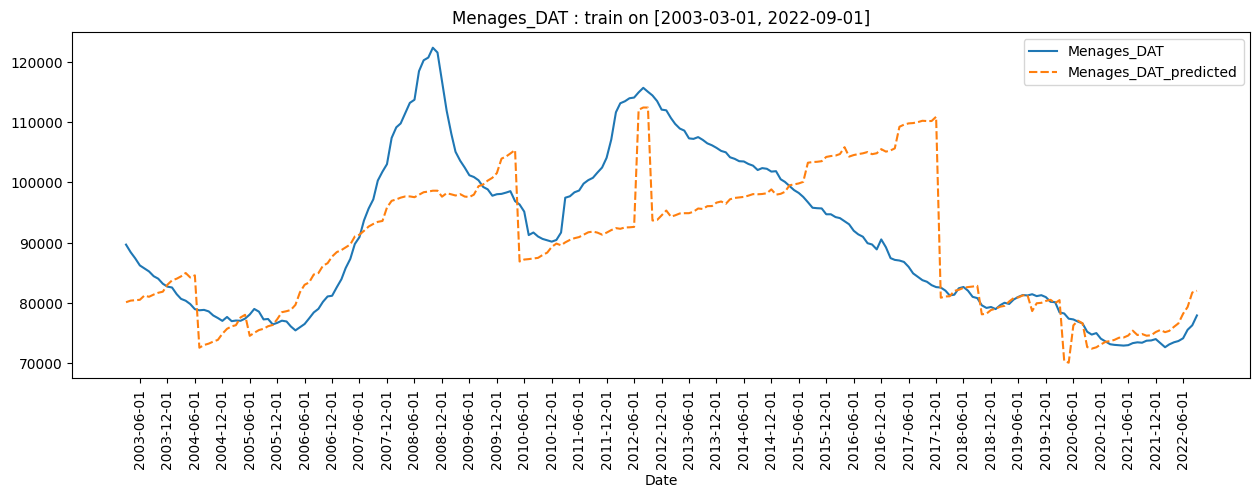

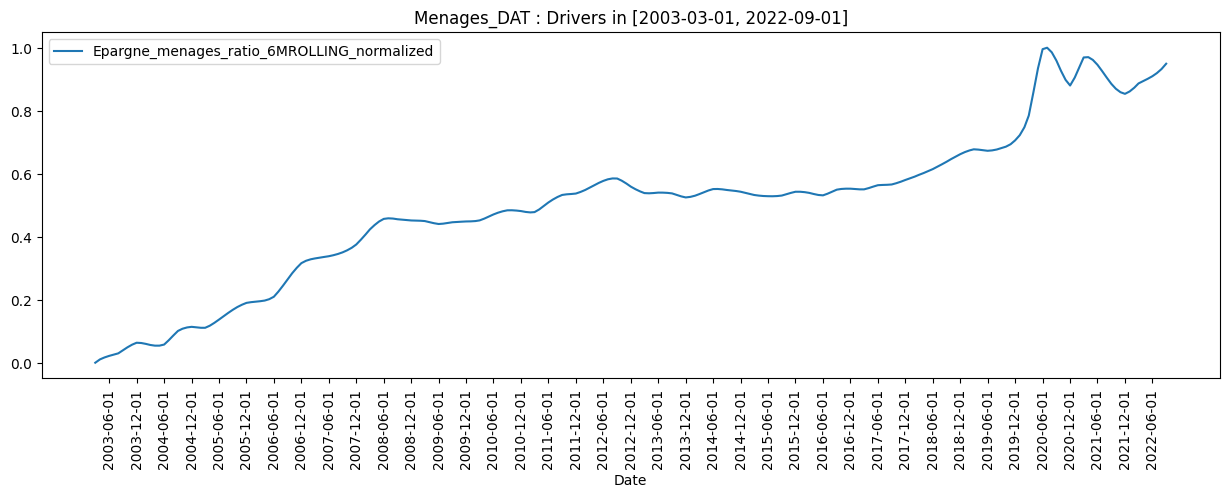

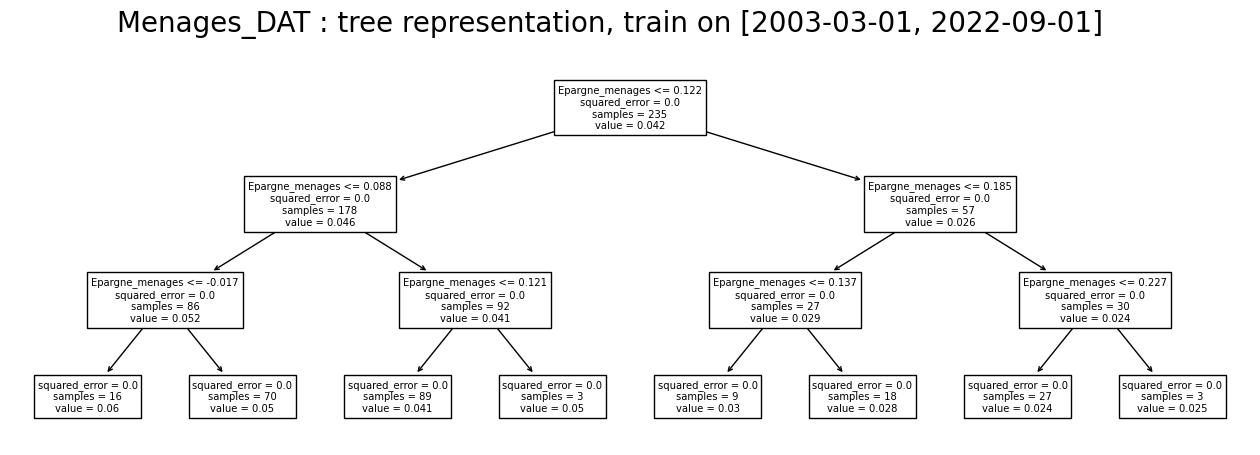

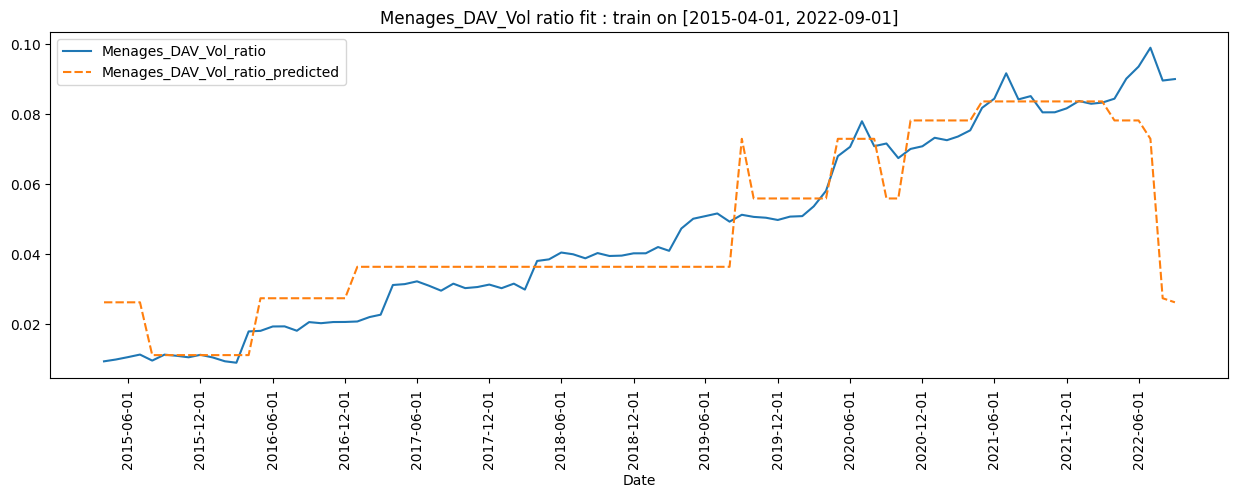

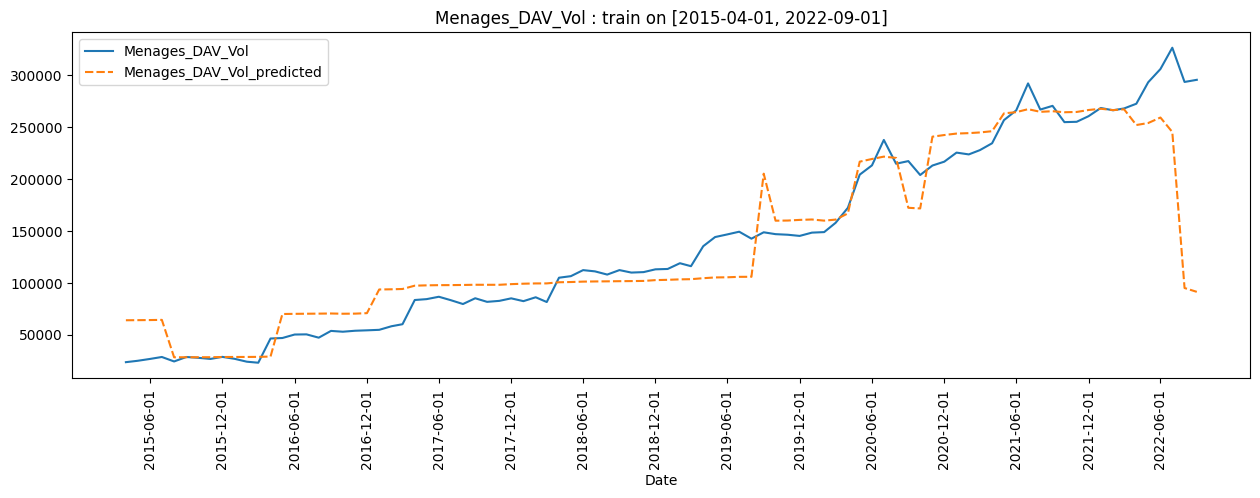

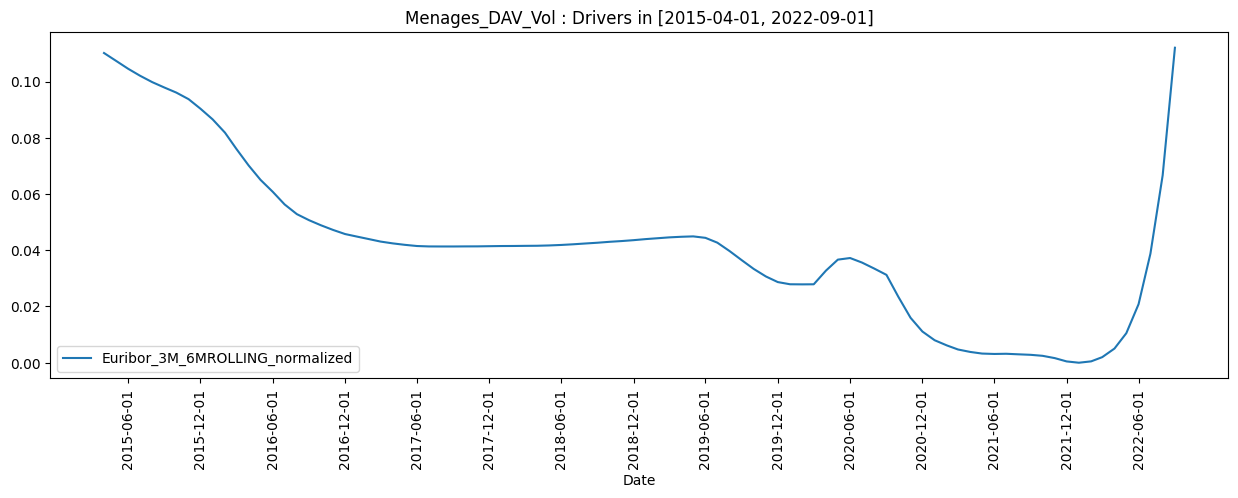

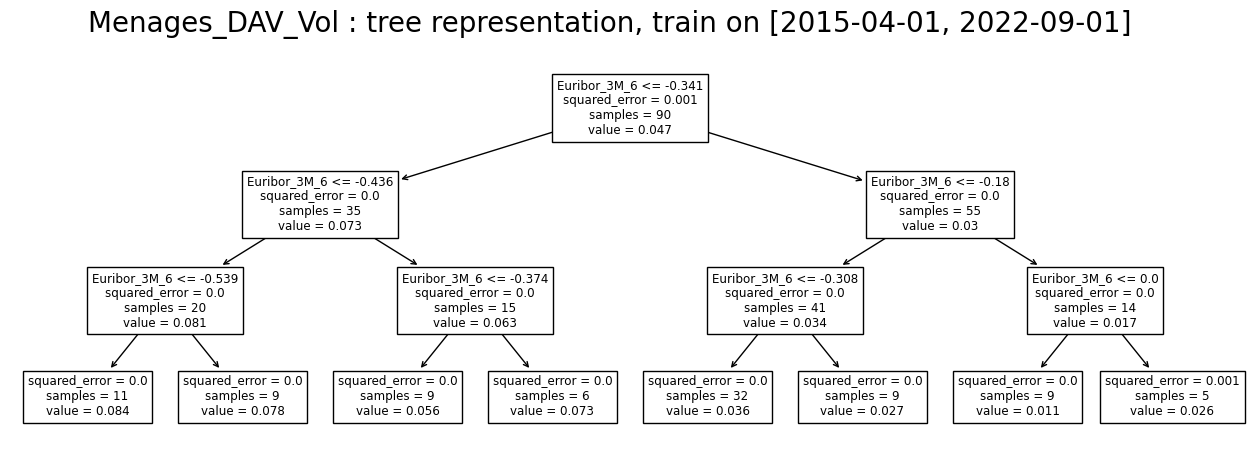

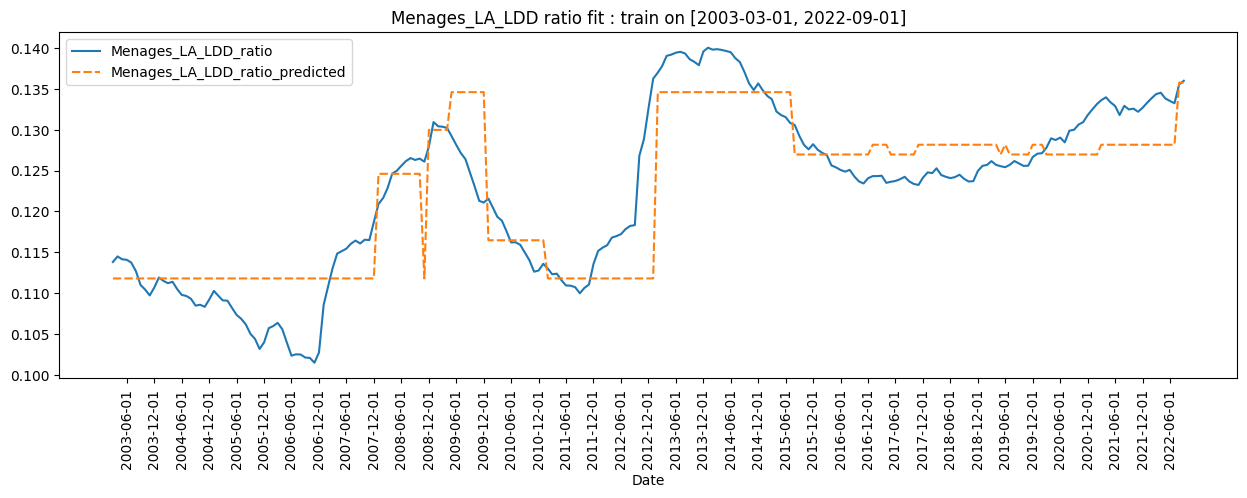

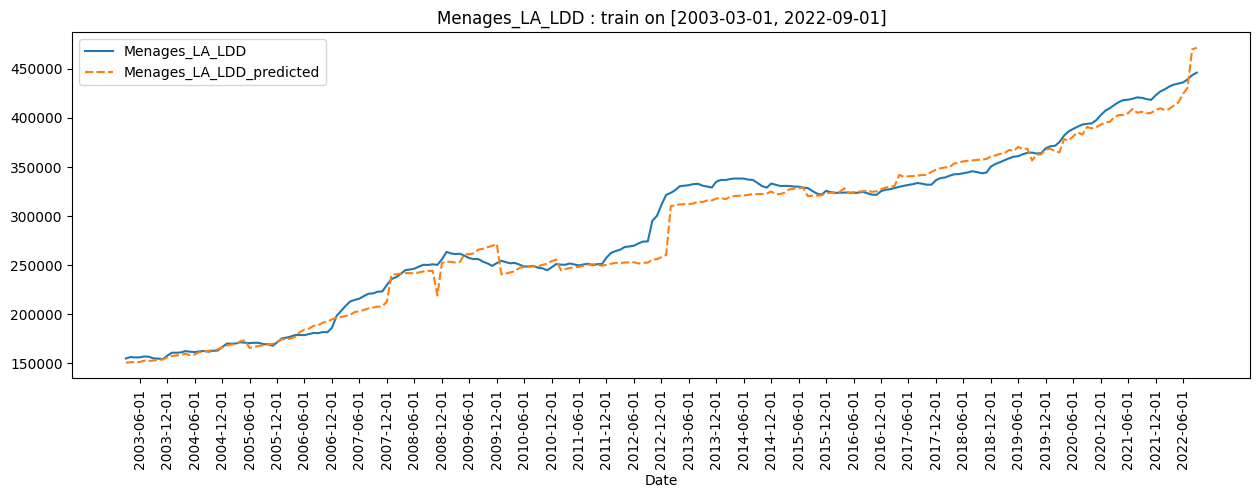

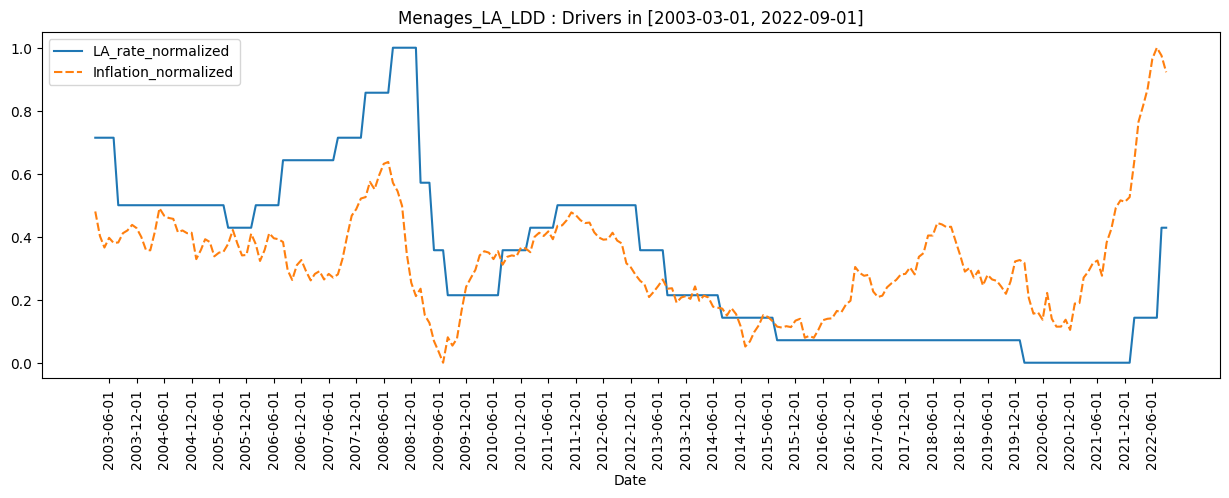

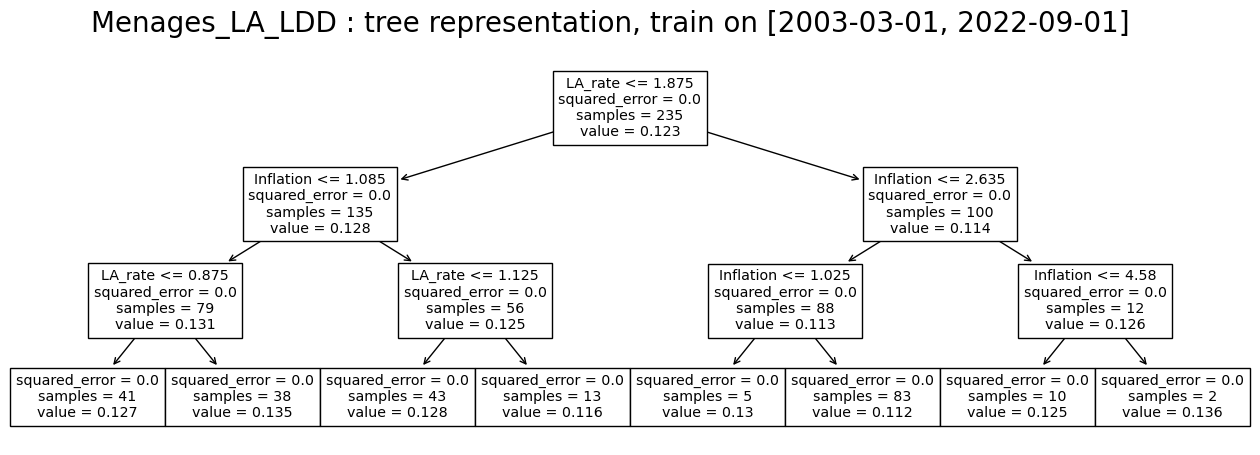

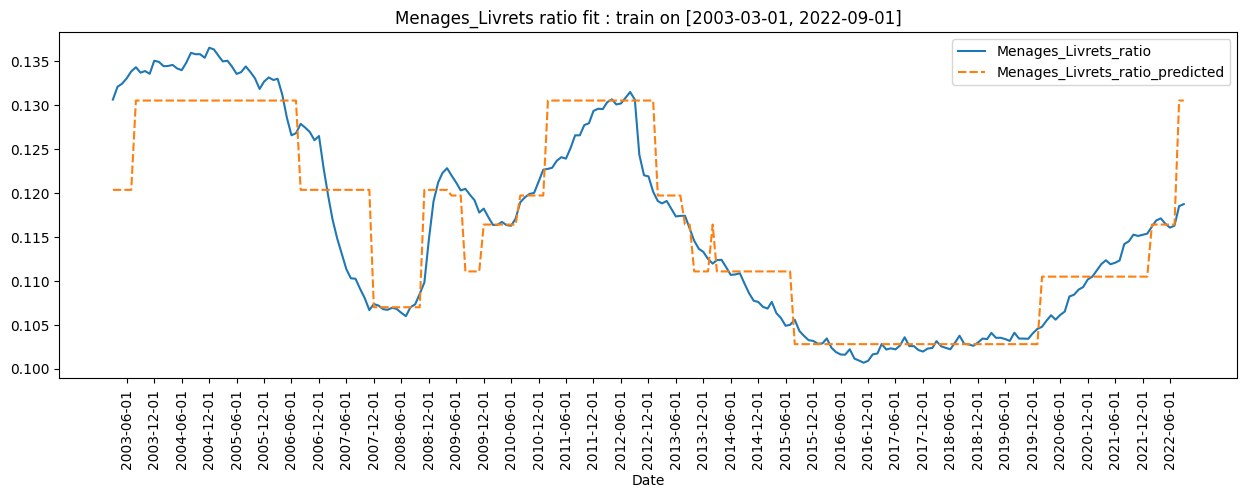

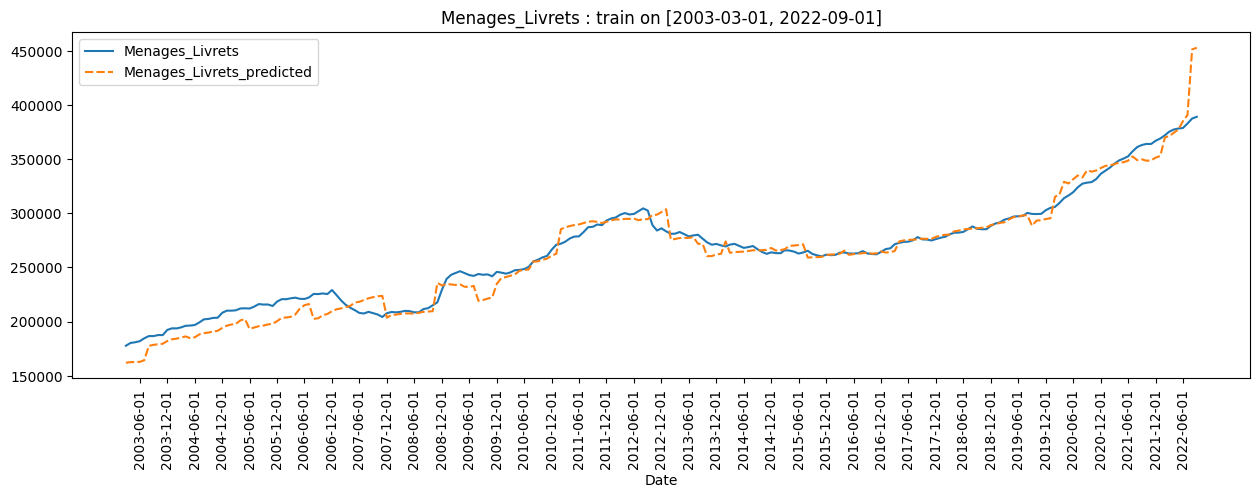

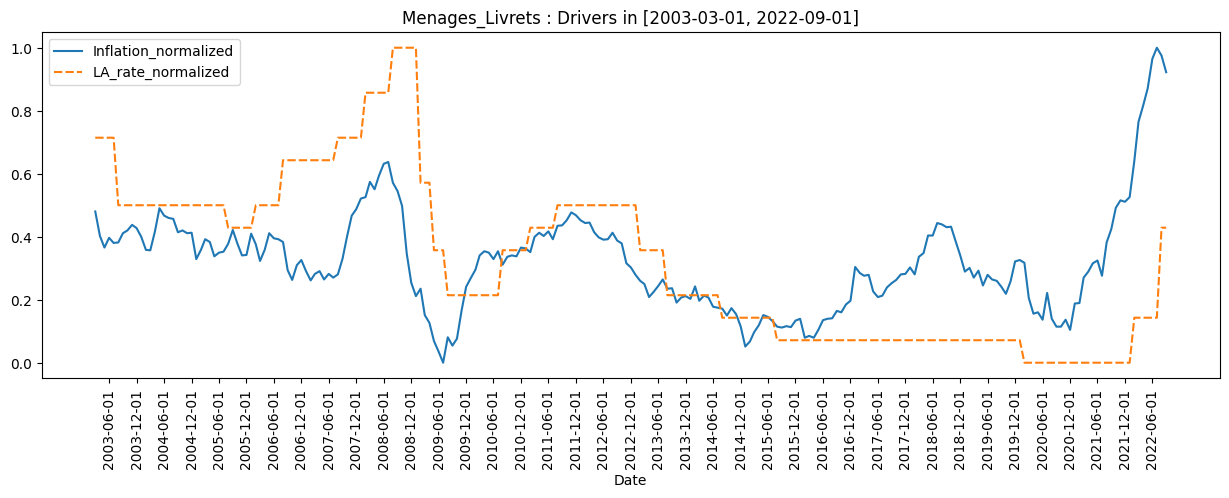

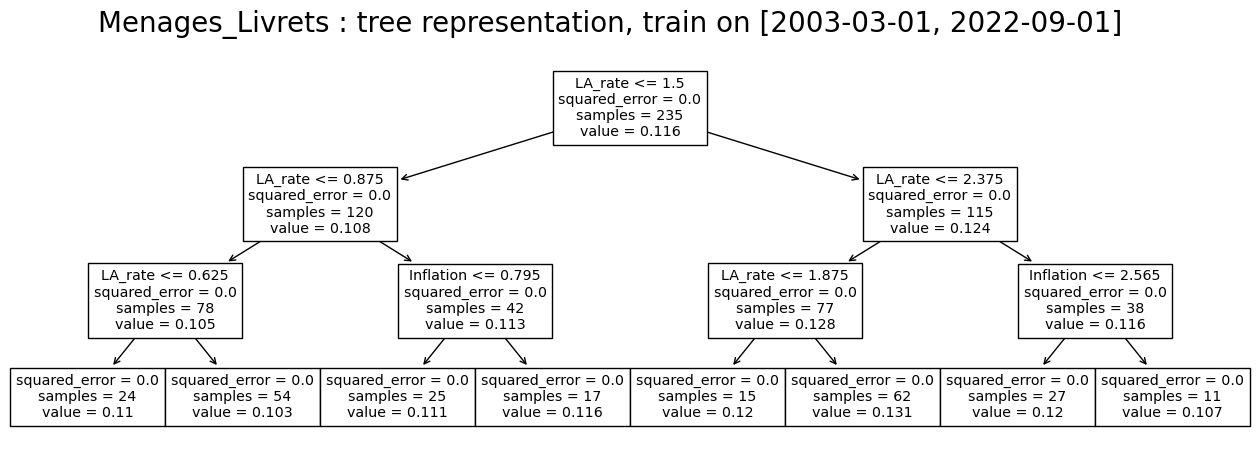

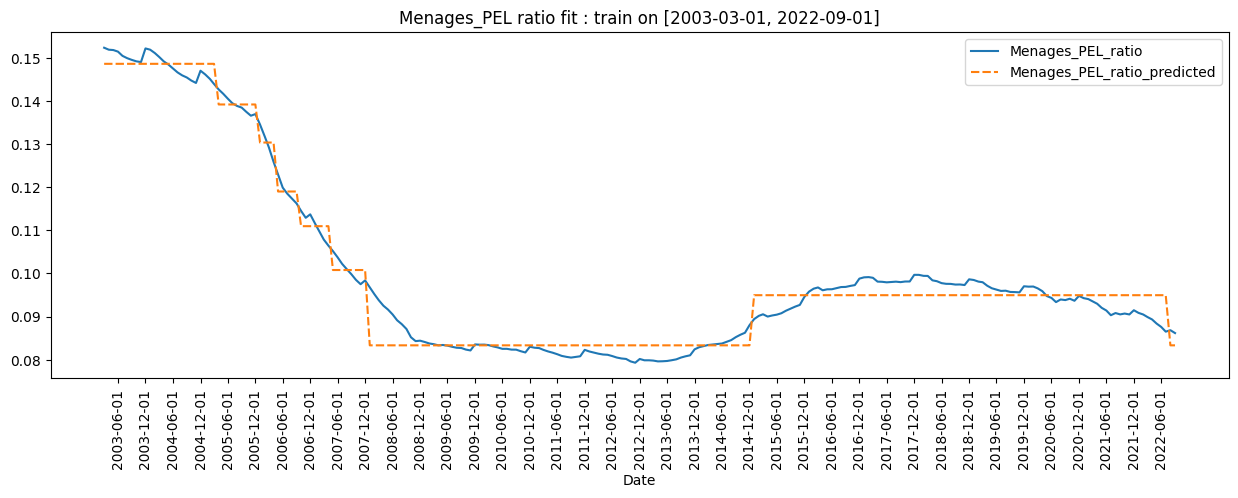

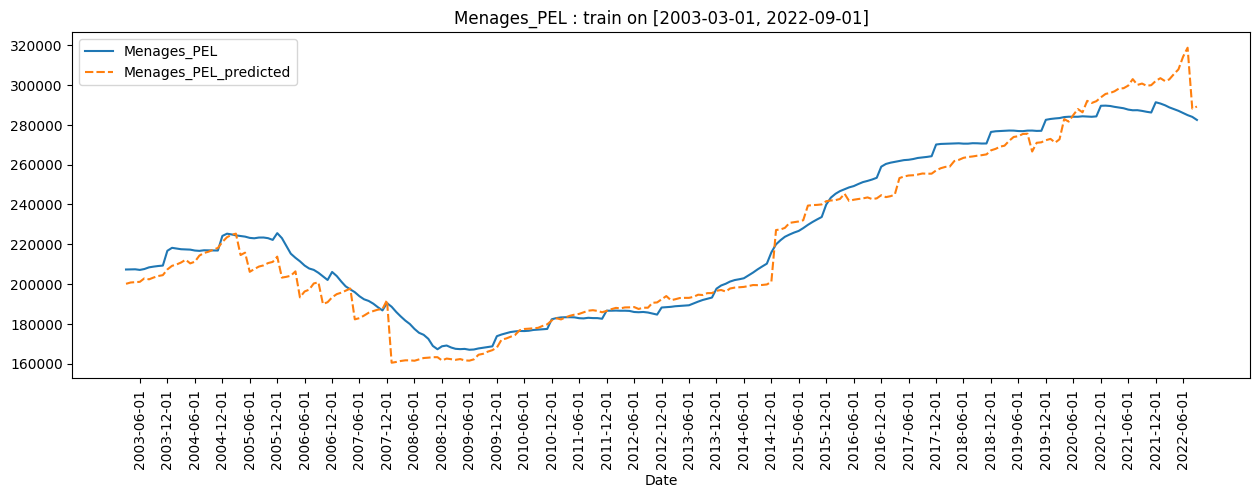

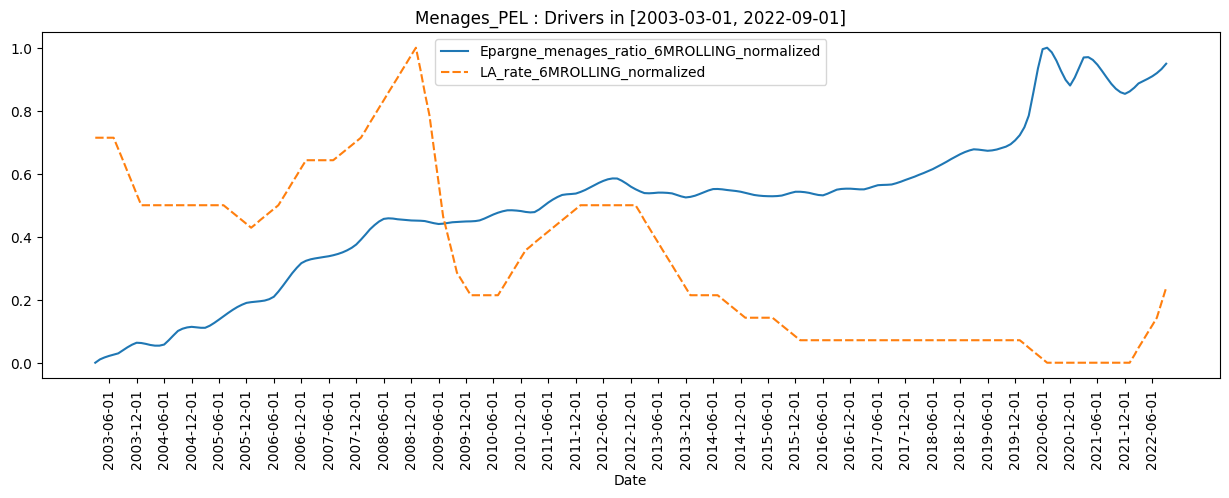

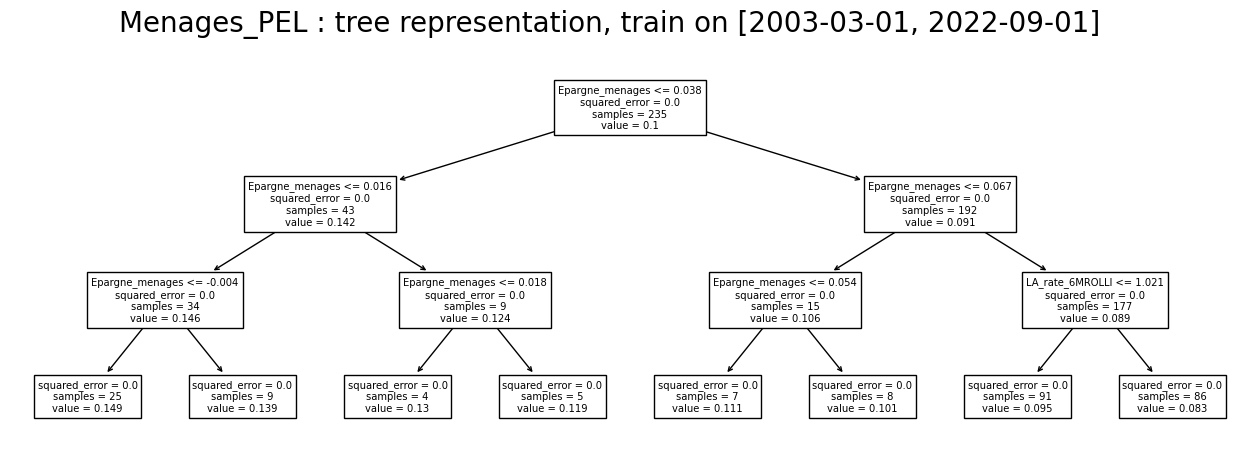

In [3]:
""" Arbitration model fit """

'''LOADING DATA SOURCES'''

scenario = 'Central' # Stagflation # Adverse

# Loading file containing historical drivers used to fit models as well as the drivers used for projection 
df_drivers = pd.read_excel('Kit_Drivers_Eco_Domestic_Market_France.xlsb', sheet_name='Drivers_France_dur', skiprows=8) #pd.read_excel('Arbitrage data v8.xlsx'. sheet_name=f'Scenario_{scenario}'. skiprows=0)
df_drivers['Date'] = pd.to_datetime(df_drivers['Date'], format='%YM%m')

# Loading file containing historical targets (here. France deposits) used to fit models
df_target = pd.read_excel('Arbitrage data v8.xlsx', sheet_name='Input_Séries_histo', skiprows=4)

# Building a common dataframe containing drivers and targets
df = df_drivers.merge(df_target, on='Date', how='left').replace('n.a.', np.nan)


'''Feature engineering'''

df['LA_minus_OAT'] = df['LA_rate'] - df['OAT_10Y'].rolling(window=5, min_periods=1).mean()
df['OAT_10Y_3YROLLING'] = df['OAT_10Y'].rolling(window=12*3, min_periods=1).mean()
df['Menages_DAV_Stable'] = df['Menages_DAV'] - df['Menages_DAV_Vol']
df['Epargne_menages_ratio'] = df['Epargne_menages_courant'] / df['RDB_courant']


'''Selecting training range and prediction range'''

# Picking historical training range in years/date (bounds included)
train_range = ('2003-03-01', '2022-09-01')
backtest_range = ('2022-04-01', '2022-09-01')
prediction_range = ('2022-06-01', '2027-12-01')


'''Selecting drivers used to make predictions as well as model types'''

target_to_drivers = {
    "Menages_AV_Euro_Corrige": ["Euribor_3M_6MROLLING", "OAT_10Y_3YROLLING"],
    "Menages_AV_UC": ["Epargne_menages_ratio_6MROLLING", "CAC40_6MROLLING"],
    "Menages_DAT": ["Epargne_menages_ratio_6MROLLING"],
    "Menages_DAV_Vol": ['Euribor_3M_6MROLLING'], 
    "Menages_LA_LDD": ["LA_rate", 'Inflation'],
    "Menages_Livrets": ["Inflation", "LA_rate"],
    "Menages_PEL": ["Epargne_menages_ratio_6MROLLING", "LA_rate_6MROLLING"]
}
reference = 'Euribor_3M'

models = {
    "Menages_AV_Euro_Corrige": DecisionTreeRegressor(max_depth=3),
    "Menages_AV_UC": DecisionTreeRegressor(max_depth=3),
    "Menages_DAT": DecisionTreeRegressor(max_depth=3),
    "Menages_DAV_Vol": DecisionTreeRegressor(max_depth=3, min_samples_leaf=5),
    "Menages_LA_LDD": DecisionTreeRegressor(max_depth=3),
    "Menages_Livrets": DecisionTreeRegressor(max_depth=3),
    "Menages_PEL": DecisionTreeRegressor(max_depth=3)
}


'''CALIBRAGE ET PREDICTION'''

df_train = df[(df['Date']<=train_range[1]) & (df['Date']>=train_range[0])]

global_shift = 0
df_train['total'] = df_train[target_to_drivers.keys()].sum(axis=1)
for (k,v) in target_to_drivers.items():
    df_train[k+'_ratio'] = df_train[k]/df_train['total']
    max_shift = 0
    for driver in v:
        if '_shifted_' in driver:
            shift_val = int(driver.split('_')[-1])
            df_train[driver] = df_train['_'.join(driver.split('_')[:-2])].shift(shift_val).fillna(0)
            max_shift = max(max_shift, shift_val)
            global_shift = max(global_shift, shift_val)
        elif '_variation' in driver:
            df_train[driver] = ((df_train['_'.join(driver.split('_')[:-1])] - df_train['_'.join(driver.split('_')[:-1])].shift(1)) / df_train['_'.join(driver.split('_')[:-1])].shift(1)).fillna(0.)
        elif '_referenced' in driver:
            df_train[driver] = (df_train['_'.join(driver.split('_')[:-1])] / df_train[reference]).fillna(0.)
        elif "_6MROLLING" in driver:
            df_train[driver] = df_train['_'.join(driver.split('_')[:-1])].rolling(6, min_periods=1).mean()
    df_train_shift = df_train[df_train['Date']>=df_train['Date'].min()+ DateOffset(months=max_shift)]
    if k=="Menages_DAV_Vol":
        df_train_shift = df_train_shift[df_train_shift['Date']>="2015-04-01"]
    models[k] = models[k].fit(df_train_shift[v], df_train_shift[k+'_ratio'])
    model = models[k]
    df_train[k+'_ratio_predicted'] = model.predict(df_train[v])
    df_train[k+'_ratio_predicted_adjusted'] = df_train[k+'_ratio_predicted'].apply(lambda x: max(x,0))

standardization_factor = df_train[[x+'_ratio_predicted_adjusted' for x in target_to_drivers.keys()]].sum(axis=1)
for (k,v) in target_to_drivers.items():
    df_train[k+'_ratio_predicted_adjusted'] = df_train[k+'_ratio_predicted_adjusted'] / standardization_factor
    df_train[k+'_predicted'] = df_train[k+'_ratio_predicted_adjusted']*df_train['total']

df_plot = df_train.copy()
df_plot = df_plot[df_plot['Date']>=df_plot['Date'].min()+ DateOffset(months=global_shift)].set_index('Date')
for k in target_to_drivers.keys():
    fig, ax =plt.subplots(1,1)
    fig.set_figheight(4.5)
    fig.set_figwidth(15.2)
    
    if k=="Menages_DAV_Vol":
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[k+'_ratio', k+'_ratio_predicted']], ax=ax)
        figure.set_title(f"{k} ratio fit : train on [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[k, k+'_predicted']], ax=ax)
        figure.set_title(f"{k} : train on [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        for driver in target_to_drivers[k]:
            df_plot[driver+'_normalized'] = (df_plot[driver] - df_plot[driver].min()) / (df_plot[driver].max() - df_plot[driver].min())

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[df_plot.index>="2015-04-01"][[d+'_normalized' for d in target_to_drivers[k]]], ax=ax)
        figure.set_title(f"{k} : Drivers in [2015-04-01, {train_range[1]}]")
        ticks = pd.Series(df_plot[df_plot.index>="2015-04-01"].index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

    else:
        figure = sns.lineplot(data=df_plot[[k+'_ratio', k+'_ratio_predicted']], ax=ax)
        figure.set_title(f"{k} ratio fit : train on [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[[k, k+'_predicted']], ax=ax)
        figure.set_title(f"{k} : train on [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

        for driver in target_to_drivers[k]:
            df_plot[driver+'_normalized'] = (df_plot[driver] - df_plot[driver].min()) / (df_plot[driver].max() - df_plot[driver].min())
        fig, ax =plt.subplots(1,1)
        fig.set_figheight(4.5)
        fig.set_figwidth(15.2)
        figure = sns.lineplot(data=df_plot[[d+'_normalized' for d in target_to_drivers[k]]], ax=ax)
        figure.set_title(f"{k} : Drivers in [{train_range[0]}, {train_range[1]}]")
        ticks = pd.Series(df_plot.index).dt.strftime('%Y-%m')
        ticks = [x for x in ticks if x[-2:] in ['06', '12']]
        figure.set_xticks(ticks)
        plt.xticks(rotation=90)
        fig.show()

    fig, ax =plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(16)

    if k=="Menages_DAV_Vol":
        tree.plot_tree(models[k], feature_names=[d[:12] for d in target_to_drivers[k]], ax=ax)
        fig.suptitle(f"{k} : tree representation, train on [2015-04-01, {train_range[1]}]", fontsize=20)
    else:  
        tree.plot_tree(models[k], feature_names=[d[:15] for d in target_to_drivers[k]], ax=ax)
        fig.suptitle(f"{k} : tree representation, train on [{train_range[0]}, {train_range[1]}]", fontsize=20)
    fig.show()




